# Warsaw AI - experiments on MNIST with entropy

In this notebook we will show why a simple entropy might serve as a good approximator of aleatoric error:

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Now let's simply normalize data:

In [2]:
x_train = x_train.reshape((-1, 28 * 28)) / 255.0
x_test = x_test.reshape((-1, 28 * 28)) / 255.0

In [3]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import regularizers

class KernelLayer(Layer):

    def __init__(self, nb_of_kernels, kernel_regularizer=None, **kwargs):
        self.nb_of_kernels = nb_of_kernels
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        super(KernelLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernels', 
                                      shape=(self.nb_of_kernels, input_shape[1]),
                                      initializer='uniform',
                                      regularizer=self.kernel_regularizer,
                                      trainable=True)
        #self.log_sigmas = self.add_weight(name='kernels', 
        #                              shape=(self.nb_of_kernels,),
        #                              initializer='uniform',
        #                              regularizer=self.kernel_regularizer,
        #                              trainable=True)
        super(KernelLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        x = K.repeat(x, self.nb_of_kernels)
        x = K.sum((x - self.kernel) ** 4, axis=-1)
        return 1 / (1 + x ** 2)
        

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_of_kernels)


Now - let's build a simple model based on [Jastrzębski et al.](https://arxiv.org/abs/1706.05394):

In [4]:
from keras.layers import Dense, Input
from keras.models import Model
from keras.regularizers import l2

def build_simple_model(
    layers=2,
    units=256,
):
    input_ = Input(shape=(28 * 28,))
    
    aux_layer = input_
    
    for _ in range(layers):
        aux_layer = Dense(
            units=units, 
            activation='relu')(aux_layer)
        
    aux_layer = KernelLayer(
        nb_of_kernels=10,
        kernel_regularizer=l2(0.001),
    )(aux_layer)
    
    output = Dense(10, activation='softmax', use_bias=False)(aux_layer)
    
    model = Model(input_, output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_simple_model()

Now - let's train it:

In [5]:
EPOCHS = 20
SPLIT = 0.1

history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=SPLIT,
    epochs=EPOCHS,
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 16s 290us/step - loss: 1.5194 - acc: 0.4350 - val_loss: 1.2380 - val_acc: 0.4868
Epoch 2/20
54000/54000 [==============================] - 16s 297us/step - loss: 0.9682 - acc: 0.6416 - val_loss: 0.8370 - val_acc: 0.6778
Epoch 3/20
54000/54000 [==============================] - 17s 306us/step - loss: 0.7963 - acc: 0.6860 - val_loss: 0.8063 - val_acc: 0.6765
Epoch 4/20
54000/54000 [==============================] - 17s 315us/step - loss: 0.7661 - acc: 0.6891 - val_loss: 0.7933 - val_acc: 0.6818
Epoch 5/20
54000/54000 [==============================] - 17s 317us/step - loss: 0.7499 - acc: 0.6911 - val_loss: 0.7904 - val_acc: 0.6775
Epoch 6/20
54000/54000 [==============================] - 17s 322us/step - loss: 0.5573 - acc: 0.7914 - val_loss: 0.3596 - val_acc: 0.8760
Epoch 7/20
54000/54000 [==============================] - 18s 335us/step - loss: 0.1506 - acc: 0.9724 - val_loss: 0.1

Now - let's compute entropies:

In [6]:
import numpy as np

EPS = 1e-16

def compute_entropy(results):
    results = np.clip(results, EPS, 1 - EPS)
    return -(results * np.log(results)).sum(axis=-1)

results = model.predict(x_test)
entropies = compute_entropy(results)

Now - let's compute misclassification flags:

In [7]:
predictions = results.argmax(axis=-1)
correctly_classified = predictions == y_test

Now - let's check if there is a correlation between misclassification and entropies:

In [8]:
from matplotlib import pyplot as plt

plt.hist(
    x=entropies[correctly_classified], 
    density=True,
    bins=20,
    alpha=0.5, 
    log=True,
    label='Correctly classified',
)
_ = plt.hist(
    x=entropies[np.logical_not(correctly_classified)],
    density=True,
    bins=20, 
    alpha=0.5, 
    log=True,
    label='Misclassified',
)

plt.title('Density of entropy for classified vs misclassifed examples.')
plt.xlabel('Entropy value')
plt.ylabel('Normalized density')
_ = plt.legend()

Now let's compute metrics on classified vs misclassified task:

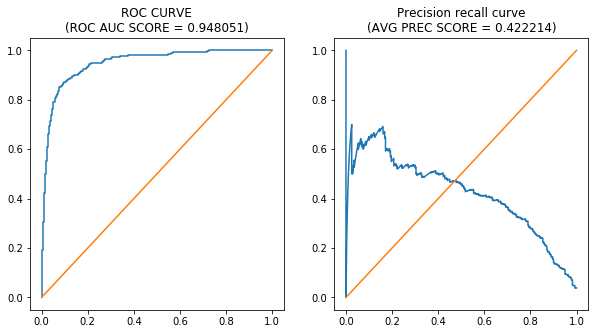

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

tpr, fpr, thresholds = roc_curve(1 - correctly_classified, entropies)
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC CURVE\n(ROC AUC SCORE = %f)' % roc_auc_score(1 - correctly_classified, entropies))

plt.subplot(1, 2, 2)

prec, rec, thresholds = precision_recall_curve(1 - correctly_classified, entropies)
plt.plot(rec, prec)
plt.plot([0, 1], [0, 1])
_ = plt.title('Precision recall curve\n(AVG PREC SCORE = %f)' % average_precision_score(1 - correctly_classified, entropies))

Also: let's have a look at the hardest cases:

In [10]:
NB_OF_IMAGES = 5

plt.figure(figsize=(10, 10 * NB_OF_IMAGES))
hardest_cases_indices = entropies.flatten().argsort()[-NB_OF_IMAGES:]

for image_nb, case_index in enumerate(hardest_cases_indices):
    plt.subplot(1, NB_OF_IMAGES, image_nb + 1)
    plt.imshow(x_test[case_index].reshape((28, 28)))
    plt.title('True class: %d' % y_test[case_index])
    plt.axis('off')

Now, let's test if it can detect _out-of-distribution_ error on the fashion MNIST dataset:

In [11]:
from keras.datasets import fashion_mnist

(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()

And normalize data accordingly:

In [12]:
x_train_f = x_train_f.reshape((-1, 28 * 28)) / 255.0
x_test_f = x_test_f.reshape((-1, 28 * 28)) / 255.0

And check if it can detect _out-of-distribution_ error:

In [13]:
results_f = model.predict(x_test_f)
entropies_f = compute_entropy(results_f)

And now - let's check if there is a correspondence:

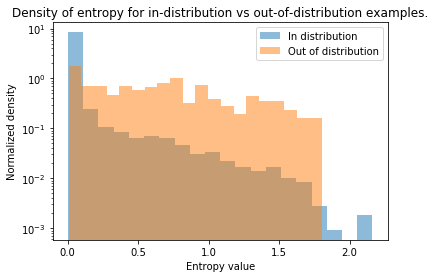

In [14]:
plt.hist(
    x=entropies, 
    density=True,
    bins=20,
    alpha=0.5, 
    label='In distribution',
    log=True,
)
_ = plt.hist(
    x=entropies[np.logical_not(correctly_classified)],
    density=True,
    bins=20, 
    alpha=0.5, 
    label='Out of distribution',
    log=True,
)

plt.title('Density of entropy for in-distribution vs out-of-distribution examples.')
plt.xlabel('Entropy value')
plt.ylabel('Normalized density')
_ = plt.legend()

And check metrics in _in-distribution_ vs _out-of-distribution_.

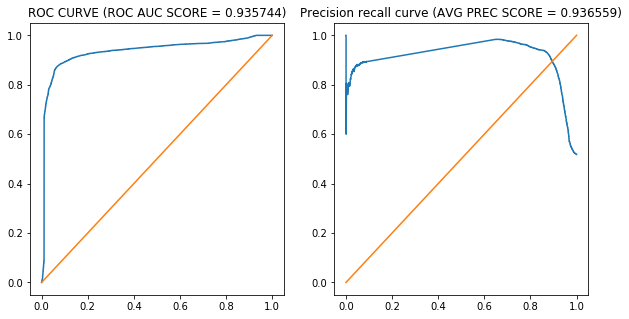

In [15]:
plt.figure(figsize=(10, 5))

out_domain = np.array([1] * len(entropies_f) + [0] * len(entropies))
scores = np.append(entropies_f, entropies)

plt.subplot(1, 2, 1)

tpr, fpr, thresholds = roc_curve(out_domain, scores)
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC CURVE (ROC AUC SCORE = %f)' % roc_auc_score(out_domain, scores))

plt.subplot(1, 2, 2)

prec, rec, thresholds = precision_recall_curve(out_domain, scores)
plt.plot(rec, prec)
plt.plot([0, 1], [0, 1])
_ = plt.title('Precision recall curve (AVG PREC SCORE = %f)' % average_precision_score(out_domain, scores))

And let's have a look at the clothes most similar to digits:

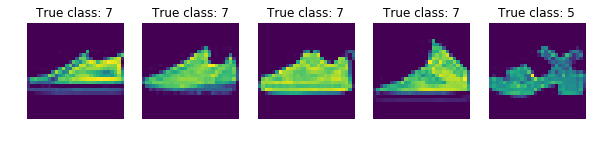

In [16]:
NB_OF_IMAGES = 5

plt.figure(figsize=(10, 10 * NB_OF_IMAGES))
hardest_cases_indices = entropies_f.flatten().argsort()[:NB_OF_IMAGES]

for image_nb, case_index in enumerate(hardest_cases_indices):
    plt.subplot(1, NB_OF_IMAGES, image_nb + 1)
    plt.imshow(x_test_f[case_index].reshape((28, 28)))
    plt.title('True class: %d' % y_test_f[case_index])
    plt.axis('off')

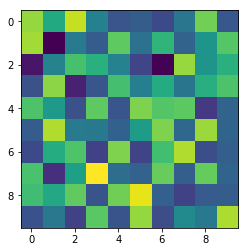

In [17]:
plt.imshow(model.layers[-1].get_weights()[0])